_Importing Required Libraries_

In [2]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: hampel in c:\python311\lib\site-packages (1.0.2)



DEPRECATION: Loading egg at c:\python311\lib\site-packages\pdfstructure-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `van_der_pol_intermittency.dat` feeds the model with the dynamics of the Van der Pol Oscillator

In [4]:
data = np.genfromtxt('../Dataset/van_der_pol_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [5]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:] # d2x/dt2
print(gradient_tt)

1.0
1        -0.000100
2        -0.000204
3        -0.000312
4        -0.000425
5        -0.000541
            ...   
139867    0.004633
139868    0.004629
139869    0.004624
139870    0.004619
139871    0.004614
Name: 1, Length: 139871, dtype: float64
2        -0.000104
3        -0.000108
4        -0.000112
5        -0.000117
6        -0.000121
            ...   
139867   -0.000005
139868   -0.000005
139869   -0.000005
139870   -0.000005
139871   -0.000005
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_दिल्ली WIND SPEED_

In [6]:
data = pd.read_csv("../Dataset/madrid.csv")
training_set = data.iloc[:, 0]
training_set

0       50
1       49
2       46
3       51
4       56
        ..
2442    23
2443    25
2444    25
2445    30
2446    32
Name: humidity, Length: 2447, dtype: int64

In [7]:
test = training_set.tail(10)
test
training_set = training_set.head(1452)
training_set

0       50
1       49
2       46
3       51
4       56
        ..
1447    53
1448    55
1449    48
1450    42
1451    36
Name: humidity, Length: 1452, dtype: int64

In [8]:
training_set = training_set.reset_index(drop=True) # sets a list of integer ranging from 0 to length of training_set as index
gradient_t = gradient_t.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_t as index
gradient_tt = gradient_tt.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_tt as index
print(gradient_t)
print(gradient_tt)

0        -0.000100
1        -0.000204
2        -0.000312
3        -0.000425
4        -0.000541
            ...   
139866    0.004633
139867    0.004629
139868    0.004624
139869    0.004619
139870    0.004614
Name: 1, Length: 139871, dtype: float64
0        -0.000104
1        -0.000108
2        -0.000112
3        -0.000117
4        -0.000121
            ...   
139865   -0.000005
139866   -0.000005
139867   -0.000005
139868   -0.000005
139869   -0.000005
Name: 1, Length: 139870, dtype: float64


In [9]:
df = pd.concat((training_set, gradient_t), axis=1) ##########[:-1]
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df, gradient_tt), axis=1) ################[:-1]
df.columns = ['y_t', 'grad_t', 'grad_tt']

In [10]:
df # DataFrame

,y_t,grad_t,grad_tt
0,50.0,-0.000100,-0.000104
1,49.0,-0.000204,-0.000108
2,46.0,-0.000312,-0.000112
3,51.0,-0.000425,-0.000117
4,56.0,-0.000541,-0.000121
...,...,...,...
139866,NaN,0.004633,-0.000005
139867,NaN,0.004629,-0.000005
139868,NaN,0.004624,-0.000005
139869,NaN,0.004619,-0.000005


## Plot of the External Forcing from Chaotic Differential Equation (_Van der Pol Oscillator_)

<Axes: >

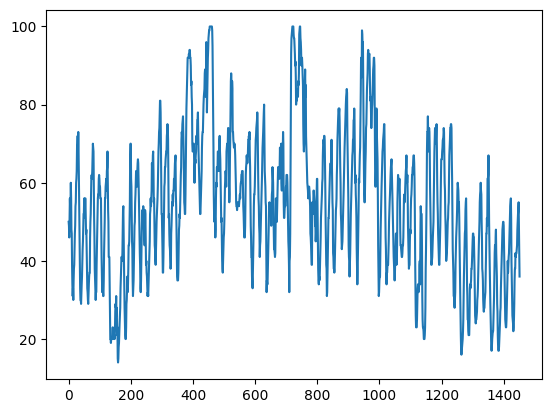

In [11]:
df.iloc[:, 0].plot()

<Axes: >

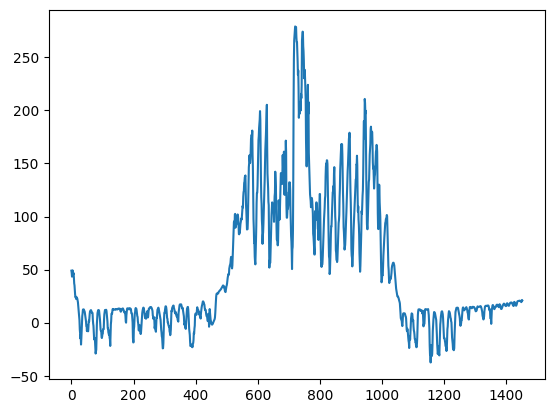

In [12]:
mu = 4
L = df.iloc[:, 2] - mu * (df.iloc[:, 1] - (df.iloc[:, 0]**2 * df.iloc[:, 1]) - (1/mu) * df.iloc[:, 0])
L.plot()

## Preprocessing the data into supervised learning

In [13]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [14]:
data = Supervised(df.values, n_in = 35, n_out = 10)
#data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
#       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
#       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
#       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)


data.drop(['var2(t-35)', 'var3(t-35)', 'var2(t-34)', 'var3(t-34)', 'var2(t-33)',
       'var3(t-33)', 'var2(t-32)', 'var3(t-32)', 'var2(t-31)', 'var3(t-31)',
    'var2(t-30)', 'var3(t-30)', 'var2(t-29)', 'var3(t-29)', 'var2(t-28)',
       'var3(t-28)', 'var2(t-27)', 'var3(t-27)', 'var2(t-26)', 'var3(t-26)',
       'var2(t-25)', 'var3(t-25)', 'var2(t-24)', 'var3(t-24)', 'var2(t-22)',
       'var3(t-22)', 'var2(t-21)', 'var3(t-21)','var2(t-23)', 'var3(t-23)',
       'var2(t-20)', 'var3(t-20)', 'var2(t-19)', 'var3(t-19)', 'var2(t-18)',
       'var3(t-18)', 'var2(t-17)', 'var3(t-17)', 'var2(t-16)', 'var3(t-16)',
       'var2(t-15)', 'var3(t-15)', 'var2(t-14)', 'var3(t-14)', 'var2(t-12)',
       'var3(t-12)', 'var2(t-13)', 'var3(t-13)', 'var3(t-11)', 'var2(t-11)', 'var3(t-11)',
       'var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)

print(data.head())
print(data.columns)

    var1(t-35)  var1(t-34)  var1(t-33)  var1(t-32)  var1(t-31)  var1(t-30)  \
35        50.0        49.0        46.0        51.0        56.0        53.0   
36        49.0        46.0        51.0        56.0        53.0        55.0   
37        46.0        51.0        56.0        53.0        55.0        60.0   
38        51.0        56.0        53.0        55.0        60.0        56.0   
39        56.0        53.0        55.0        60.0        56.0        48.0   

    var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  ...  var3(t+6)  var1(t+7)  \
35        55.0        60.0        56.0        48.0  ...  -0.000027       34.0   
36        60.0        56.0        48.0        47.0  ...  -0.000023       36.0   
37        56.0        48.0        47.0        39.0  ...  -0.000020       40.0   
38        48.0        47.0        39.0        34.0  ...  -0.000017       43.0   
39        47.0        39.0        34.0        31.0  ...  -0.000014       45.0   

    var2(t+7)  var3(t+7)  var1(t+8)  var2(t+

In [15]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [16]:
trainy = train[:,-30:]
trainX = train[:,:-30]

In [17]:
forecasty = forecast[:,-30:]
forecastX = forecast[:,:-30]

In [18]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1407, 1, 37) (1407, 30) (1, 1, 37)


In [19]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)
splitr = 0.8

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(30))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)



Epoch 1/500

18/18 [==============================] - 5s 61ms/step - loss: 3458.9514 - val_loss: 1887.1761
Epoch 2/500
18/18 [==============================] - 0s 8ms/step - loss: 3366.7793 - val_loss: 1846.7880
Epoch 3/500
18/18 [==============================] - 0s 9ms/step - loss: 3329.3772 - val_loss: 1820.6962
Epoch 4/500
18/18 [==============================] - 0s 10ms/step - loss: 3290.8271 - val_loss: 1790.7227
Epoch 5/500
18/18 [==============================] - 0s 8ms/step - loss: 3249.0798 - val_loss: 1757.2061
Epoch 6/500
18/18 [==============================] - 0s 9ms/step - loss: 3198.6587 - val_loss: 1724.4703
Epoch 7/500
18/18 [==============================] - 0s 9ms/step - loss: 3161.6528 - val_loss: 1696.5828
Epoch 8/500
18/18 [==============================] - 0s 9ms/step - loss: 3106.5229 - val_loss: 1652.7584
Epoch 9/500
18/18 [==============================] - 0s 9ms/step - loss: 3057.1189 - val_loss: 1622.8435
Epoch 10/500
18/18 [==============================

In [20]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 1s 617ms/step


In [21]:
forecastX.shape

(1, 1, 37)

In [22]:
forecast_without_mc.shape

(1, 37)

In [23]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [24]:
inv_yhat_without_mc.shape

(1, 67)

In [25]:
fforecast = inv_yhat_without_mc[:,-30:]

In [26]:
final_forecast = fforecast[:,0:29:3]

In [27]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [28]:
# Calculate RMSE and MAE
def evaluate_forecast(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# Assuming you have already forecasted values in the variable final_forecast

# Extract the actual values from the test dataset
actual_values = test.values

# Forecasted values from your model
forecast_values = final_forecast[0]  # Assuming final_forecast contains the forecasted values for the first test instance

# Calculate RMSE and MAE
rmse, mae = evaluate_forecast(actual_values, forecast_values)

# Print RMSE and MAE
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 26.77753568320091
Mean Absolute Error (MAE): 26.437639264017342
